## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [5]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,NaN,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [6]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [7]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [8]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [9]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [10]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [11]:
target = 'survived'

In [12]:
vars_num = data[['pclass', 'survived', 'age', 'sibsp', 'fare']]

vars_cat = data[['sex', 'cabin', 'embarked', 'title']]

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 1309
Number of categorical variables: 1309


### Find missing values in variables

In [13]:
# first in numerical variables
vars_num.isnull().sum()


pclass        0
survived      0
age         263
sibsp         0
fare          1
dtype: int64

In [14]:
# now in categorical variables
vars_cat.isnull().sum()



sex            0
cabin       1014
embarked       2
title          0
dtype: int64

In [43]:
zip('2', '5')

### Determine cardinality of categorical variables

In [63]:
# Using for loop to count
# The number of unique categories in a variable is called cardinality
cat_unique_count = []

for col in vars_cat.columns:
    unique = vars_cat[col].unique()
    cat_unique_count.append( 'There are ' + str(len(unique)) + ' diffrent types in the caregory ' + col)


In [64]:
cat_unique_count

['There are 2 diffrent types in the caregory sex',
 'There are 182 diffrent types in the caregory cabin',
 'There are 4 diffrent types in the caregory embarked',
 'There are 5 diffrent types in the caregory title']

### Determine the distribution of numerical variables

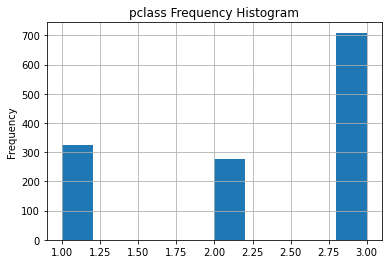

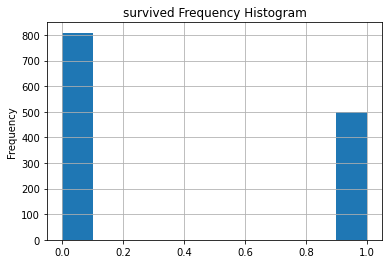

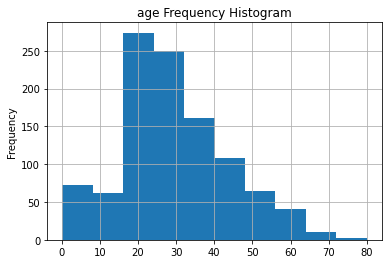

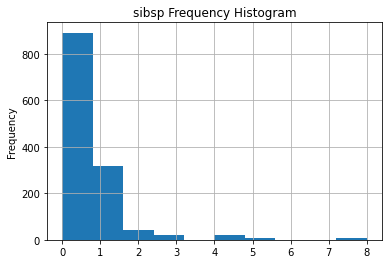

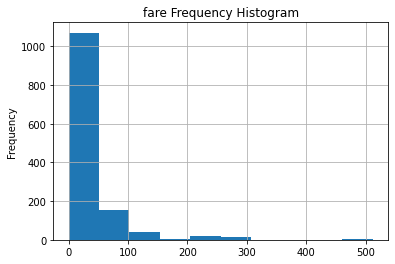

In [84]:
# Using for loop to count
# The number of unique categories in a variable is called cardinality
def dist_func (df, column):
    vars_num[column].hist()
    plt.gca().set(title= column + ' Frequency Histogram', ylabel='Frequency'); 
    plt.show()

for col in vars_num.columns:
    dist_func(vars_num, col)




## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [85]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [99]:
X_train.columns

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin', 'embarked',
       'title'],
      dtype='object')

In [100]:
# This function let you extract numbers from a string
def extract_num_from_string(string: str) -> int:
  return ''.join(re.findall('\d', string))

In [ ]:
# Loop to extract all num from each column (use when needed)
for i in X_train.columns:
    col_'{}'.format(i)


In [101]:
# this line of code used when there are no na values or full strings X_train['cabin'].str.extract('(\d+)').astype(int)

# a loop to apply the function of each entry of the numirical columns
cabin = []


for num in X_train['cabin']:
    num_func = extract_num_from_string(str(num))

    cabin.append(num_func)



In [103]:
X_train['cabin_num'] = cabin

In [104]:
X_train

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,cabin_num
1118,3,male,25.0000,0,0,7.9250,NaN,S,Mr,
44,1,female,41.0000,0,0,134.5000,E40,C,Miss,40
1072,3,male,NaN,0,0,7.7333,NaN,Q,Mr,
1130,3,female,18.0000,0,0,7.7750,NaN,S,Miss,
574,2,male,29.0000,1,0,21.0000,NaN,S,Mr,
...,...,...,...,...,...,...,...,...,...,...
763,3,female,0.1667,1,2,20.5750,NaN,S,Miss,
835,3,male,NaN,0,0,8.0500,NaN,S,Mr,
1216,3,female,NaN,0,0,7.7333,NaN,Q,Miss,
559,2,female,20.0000,0,0,36.7500,NaN,S,Miss,


### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [112]:
X_train2 = X_train

In [115]:
X_train2 = X_train2.fillna(X_train2.median(numeric_only=True))


### Replace Missing data in categorical variables with the string **Missing**

In [116]:
X_train2

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,cabin_num
1118,3,male,25.0000,0,0,7.9250,NaN,S,Mr,
44,1,female,41.0000,0,0,134.5000,E40,C,Miss,40
1072,3,male,28.0000,0,0,7.7333,NaN,Q,Mr,
1130,3,female,18.0000,0,0,7.7750,NaN,S,Miss,
574,2,male,29.0000,1,0,21.0000,NaN,S,Mr,
...,...,...,...,...,...,...,...,...,...,...
763,3,female,0.1667,1,2,20.5750,NaN,S,Miss,
835,3,male,28.0000,0,0,8.0500,NaN,S,Mr,
1216,3,female,28.0000,0,0,7.7333,NaN,Q,Miss,
559,2,female,20.0000,0,0,36.7500,NaN,S,Miss,


### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [146]:
def rare_labels_with_col(df, var, rare_percent, col):

    df = df.copy()
    #percentage of observation per category
    percent = df.groupby(var)[col].count() / len(df)
    return percent[percent < rare_percent]

In [133]:
def rare_labels(df, var, rare_percent):

    df = df.copy()
    #percentage of observation per category
    percent = df.groupby(var).count() / len(df)
    return percent[percent < rare_percent]

In [200]:
to_remove_percent = []

for col in X_train2.columns:
    for var in X_train2:
        less_than_5_precent = rare_labels_with_col(X_train2, var, 0.05, col)
        for value in less_than_5_precent:
            to_remove_percent.append(value)
            X_train3 = X_train2[X_train2[col] != f'{value}']
          #  v.append(value)



In [202]:
to_remove_percent

[0.0009551098376313276,
 0.0009551098376313276,
 0.0019102196752626551,
 0.0019102196752626551,
 0.0009551098376313276,
 0.007640878701050621,
 0.009551098376313277,
 0.0038204393505253103,
 0.0066857688634192934,
 0.0038204393505253103,
 0.004775549188156638,
 0.0019102196752626551,
 0.0038204393505253103,
 0.007640878701050621,
 0.0038204393505253103,
 0.0038204393505253103,
 0.0009551098376313276,
 0.0028653295128939827,
 0.0028653295128939827,
 0.0028653295128939827,
 0.0019102196752626551,
 0.0038204393505253103,
 0.014326647564469915,
 0.012416427889207259,
 0.02865329512893983,
 0.0028653295128939827,
 0.021967526265520534,
 0.018147086914995225,
 0.03151862464183381,
 0.03151862464183381,
 0.0009551098376313276,
 0.02005730659025788,
 0.0009551098376313276,
 0.03629417382999045,
 0.027698185291308502,
 0.026743075453677174,
 0.0009551098376313276,
 0.025787965616045846,
 0.0028653295128939827,
 0.02387774594078319,
 0.030563514804202482,
 0.0009551098376313276,
 0.0191021967526

In [201]:
l = []
for i in to_remove_percent:
    for d in i:
         l.append(d)

TypeError: 'float' object is not iterable

In [198]:
l

[0.0009551098376313276,
 0.0009551098376313276,
 0.0019102196752626551,
 0.0019102196752626551,
 0.0009551098376313276,
 0.007640878701050621,
 0.009551098376313277,
 0.0038204393505253103,
 0.0066857688634192934,
 0.0038204393505253103,
 0.004775549188156638,
 0.0019102196752626551,
 0.0038204393505253103,
 0.007640878701050621,
 0.0038204393505253103,
 0.0038204393505253103,
 0.0009551098376313276,
 0.0028653295128939827,
 0.0028653295128939827,
 0.0028653295128939827,
 0.0019102196752626551,
 0.0038204393505253103,
 0.014326647564469915,
 0.012416427889207259,
 0.02865329512893983,
 0.0028653295128939827,
 0.021967526265520534,
 0.018147086914995225,
 0.03151862464183381,
 0.03151862464183381,
 0.0009551098376313276,
 0.02005730659025788,
 0.0009551098376313276,
 0.03629417382999045,
 0.027698185291308502,
 0.026743075453677174,
 0.0009551098376313276,
 0.025787965616045846,
 0.0028653295128939827,
 0.02387774594078319,
 0.030563514804202482,
 0.0009551098376313276,
 0.0191021967526

In [193]:
f = []
for num in range(len(to_remove_percent)):
    for i in to_remove_percent:
        for x in i:
            X_train2 = X_train2[X_train2[num] != x]

KeyError: 0

100

In [167]:
b

0.0009551098376313276

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

### Scale the variables

- Use the standard scaler from Scikit-learn

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**